In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

The purpose of this notebook is to apply some basic ML regression algorithms to the features selected in the feature_extraction notebook. Cursory hyperparameter tuning will be applied for enhanced performance.

# Table of Contents<a id='ToC'></a>

- Data Ingestion [1](#Ingestion)

- Feature Engineering [2](#Engineering)

- ML Algorithms [3](#Algorithms)

- Lasso Regression [4](#Lasso)

- Random Forest [5](#RF)

- XGBoost [6](#XGB)

- Neural Network [7](#NN)

- Combining results [8](#Ensemble)

# Data Ingestion [Return](#ToC)<a id='Ingestion'></a>

In [2]:
features = pd.read_csv('../data/data_features.csv')

In [3]:
features.head(5)

,YearRemodAdd,YearBuilt,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,Neighborhood,ExterQual,...,GarageFinish,FullBath,GarageType,MSSubClass,Foundation,FireplaceQu,Fireplaces,TotRmsAbvGrd,HeatingQC,SalePrice
0,2003,2003,856,856,548,2,1710,7,CollgCr,Gd,...,RFn,2,Attchd,60,PConc,NaN,0,8,Ex,208500
1,1976,1976,1262,1262,460,2,1262,6,Veenker,TA,...,RFn,2,Attchd,20,CBlock,TA,1,6,Ex,181500
2,2002,2001,920,920,608,2,1786,7,CollgCr,Gd,...,RFn,2,Attchd,60,PConc,TA,1,6,Ex,223500
3,1970,1915,961,756,642,3,1717,7,Crawfor,TA,...,Unf,1,Detchd,70,BrkTil,Gd,1,7,Gd,140000
4,2000,2000,1145,1145,836,3,2198,8,NoRidge,Gd,...,RFn,2,Attchd,60,PConc,TA,1,9,Ex,250000


In [4]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 22 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   YearRemodAdd  1460 non-null   int64 
 1   YearBuilt     1460 non-null   int64 
 2   1stFlrSF      1460 non-null   int64 
 3   TotalBsmtSF   1460 non-null   int64 
 4   GarageArea    1460 non-null   int64 
 5   GarageCars    1460 non-null   int64 
 6   GrLivArea     1460 non-null   int64 
 7   OverallQual   1460 non-null   int64 
 8   Neighborhood  1460 non-null   object
 9   ExterQual     1460 non-null   object
 10  BsmtQual      1423 non-null   object
 11  KitchenQual   1460 non-null   object
 12  GarageFinish  1379 non-null   object
 13  FullBath      1460 non-null   int64 
 14  GarageType    1379 non-null   object
 15  MSSubClass    1460 non-null   int64 
 16  Foundation    1460 non-null   object
 17  FireplaceQu   770 non-null    object
 18  Fireplaces    1460 non-null   int64 
 19  TotRms

# Feature Engineering [Return](#ToC) <a id = 'Engineering'></a>

In [5]:
def replace_quality_labels(df):
    for col in ['ExterQual', 'BsmtQual', 'KitchenQual', 'FireplaceQu', 'HeatingQC']:
        df[col] = df[col].fillna('None')
        df[col] = df[col].map({'None': 0, 'Po':1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5})
    return df

In [6]:
def replace_garage_finish(df):
    df['GarageFinish'] = df['GarageFinish'].fillna('None')
    df['GarageFinish'] = df['GarageFinish'].map({'None': 0, 'Unf': 1, 'RFn': 2, 'Fin': 3})
    return df

In [7]:
def get_dummies(df):
    columns = ['Neighborhood', 'GarageType', 'Foundation', 'MSSubClass']
    for col in columns:
        OHE_data = pd.get_dummies(df[col], drop_first = True, prefix = col)
        df = pd.concat([df, OHE_data], axis = 1)
        df.drop(col, inplace = True, axis = 1)
    return df

In [8]:
features['MSSubClass'] = features['MSSubClass'].astype(object)
features = replace_quality_labels(features)
features = replace_garage_finish(features)
features = get_dummies(features)

In [9]:
features.head(5)

,YearRemodAdd,YearBuilt,1stFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,ExterQual,BsmtQual,...,MSSubClass_60,MSSubClass_70,MSSubClass_75,MSSubClass_80,MSSubClass_85,MSSubClass_90,MSSubClass_120,MSSubClass_160,MSSubClass_180,MSSubClass_190
0,2003,2003,856,856,548,2,1710,7,4,4,...,1,0,0,0,0,0,0,0,0,0
1,1976,1976,1262,1262,460,2,1262,6,3,4,...,0,0,0,0,0,0,0,0,0,0
2,2002,2001,920,920,608,2,1786,7,4,4,...,1,0,0,0,0,0,0,0,0,0
3,1970,1915,961,756,642,3,1717,7,3,3,...,0,1,0,0,0,0,0,0,0,0
4,2000,2000,1145,1145,836,3,2198,8,4,4,...,1,0,0,0,0,0,0,0,0,0


In [10]:
feature_labels = features.columns

# Algorithms [Return](#ToC) <a id = 'Algorithms'></a>

In [11]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [12]:
X = features.drop('SalePrice', axis = 1)
y = features['SalePrice']

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [14]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [15]:
def summary_plots(pred, true, labels = None, weights = None, plot_importance = True):
    f, axes = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(15)
    sns.regplot(x = pred, y = true, ax = axes[0])
    axes[0].set_xlabel('Predicted house price')
    axes[0].set_ylabel('Actual house price')
    sns.regplot(x = pred, y = true - pred, ax = axes[1])
    axes[1].set_xlabel('Predicted house price')
    axes[1].set_ylabel('Residual house price')
    plt.show()
    
    if plot_importance:
        coefficients = pd.DataFrame(zip(labels, weights), columns = ['Feature', 'Weight'])
        coefficients.sort_values(by = 'Weight', inplace = True)
        f, axes = plt.subplots(1, 2)
        f.set_figheight(5)
        f.set_figwidth(13)
        sns.barplot(x = 'Feature', y = 'Weight', data = coefficients.iloc[:5, :], ax = axes[0])
        axes[0].tick_params(labelrotation=90, axis = 'x')

        sns.barplot(x = 'Feature', y = 'Weight', data = coefficients.iloc[-5:, :], ax = axes[1])
        axes[1].tick_params(labelrotation=90, axis = 'x')
        plt.tight_layout()
        plt.show()

In [16]:
def plot_CV_scores(cv_obj):
    f, axes = plt.subplots(1, 2)
    f.set_figheight(5)
    f.set_figwidth(15)

    for i in np.arange(4):
        sns.lineplot(x = np.arange(len(cv_obj.cv_results_['split'+str(i)+'_train_score'])), 
                 y = cv_obj.cv_results_['split'+str(i)+'_train_score'], ax = axes[0])
    sns.lineplot(x = np.arange(len(cv_obj.cv_results_['mean_train_score'])), 
                 y = cv_obj.cv_results_['mean_train_score'], color =  'k', ax = axes[0])
    
    for i in np.arange(4):
        sns.lineplot(x = np.arange(len(cv_obj.cv_results_['split'+str(i)+'_test_score'])), 
                 y = cv_obj.cv_results_['split'+str(i)+'_test_score'], ax = axes[1])
    sns.lineplot(x = np.arange(len(cv_obj.cv_results_['mean_test_score'])), 
                 y = cv_obj.cv_results_['mean_test_score'], color =  'k', ax = axes[1])

# Lasso Regression [Return](#ToC) <a id = 'Lasso'></a>

In [17]:
params = {'alpha': np.arange(1, 1000, 10)}
lasso_reg = Lasso()
cv_lasso = GridSearchCV(lasso_reg, 
                        param_grid = params, 
                        cv = 5, 
                        return_train_score = True,
                        scoring = 'neg_root_mean_squared_error')

cv_lasso.fit(X_train, y_train)
print(cv_lasso.best_params_)

lasso_final = Lasso(**cv_lasso.best_params_)
lasso_final.fit(X_train, y_train)
results_lasso = lasso_final.predict(X_test)
print(f'Pearson co-efficient: {lasso_final.score(X_test, y_test)}')
print(f'RMSE: {np.sqrt(mean_squared_error(results_lasso, y_test.values))}')
print(f'MAD: {stats.median_absolute_deviation(results_lasso - y_test.values)}')

{'alpha': 471}
Pearson co-efficient: 0.848015167675698
RMSE: 34143.42165735642
MAD: 20219.492935153743


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.



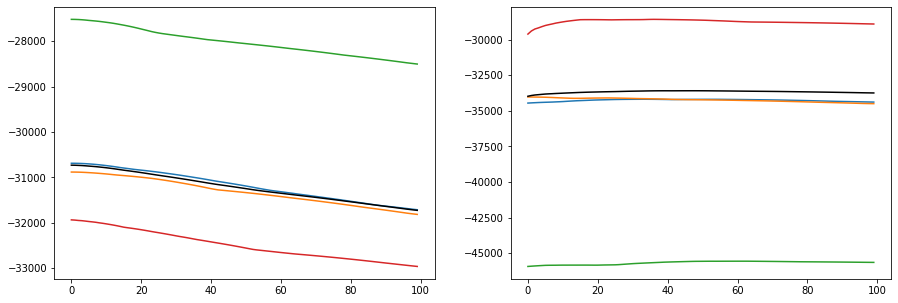

In [18]:
plot_CV_scores(cv_lasso)

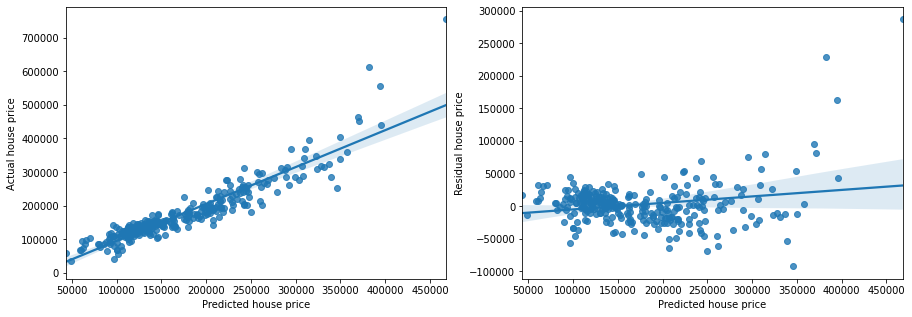

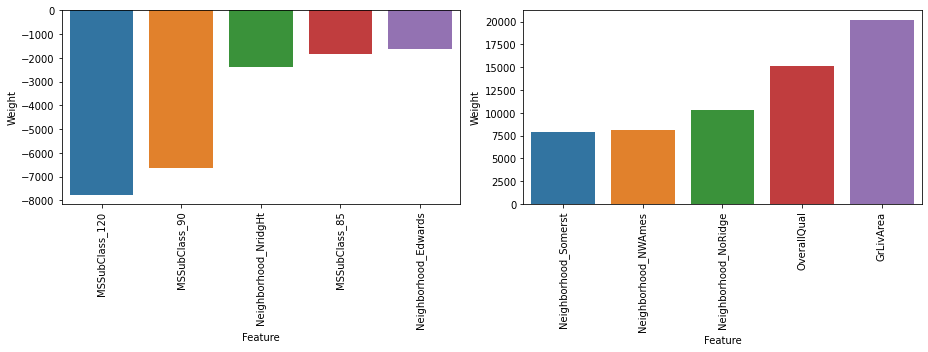

In [19]:
summary_plots(results_lasso, y_test.values, feature_labels, lasso_final.coef_)

# Random Forest [Return](#ToC) <a id = 'RF'></a>

In [20]:
param_grid = {
    'max_features': ['auto', 'sqrt'],
    'oob_score': [True],
    'max_depth': [20, 30, 40, 50],
    'n_estimators': [200, 300, 400]
}

# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, 
                              param_grid = param_grid, 
                              cv = 5, 
                              return_train_score = True,
                              scoring = 'neg_root_mean_squared_error')
_ = grid_search_rf.fit(X_train, y_train)
print(grid_search_rf.best_params_)
rf_final = RandomForestRegressor(**grid_search_rf.best_params_)
rf_final.fit(X_train, y_train)
results_rf = rf_final.predict(X_test)
print(f'Pearson co-efficient: {rf_final.score(X_test, y_test)}')
print(f'RMSE: {np.sqrt(mean_squared_error(results_rf, y_test.values))}')
print(f'MAD: {stats.median_absolute_deviation(results_rf - y_test.values)}')

{'max_depth': 40, 'max_features': 'sqrt', 'n_estimators': 400, 'oob_score': True}
Pearson co-efficient: 0.8928333402646029
RMSE: 28670.59885501385
MAD: 16170.204973300017


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\ipykernel_launcher.py:23: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.



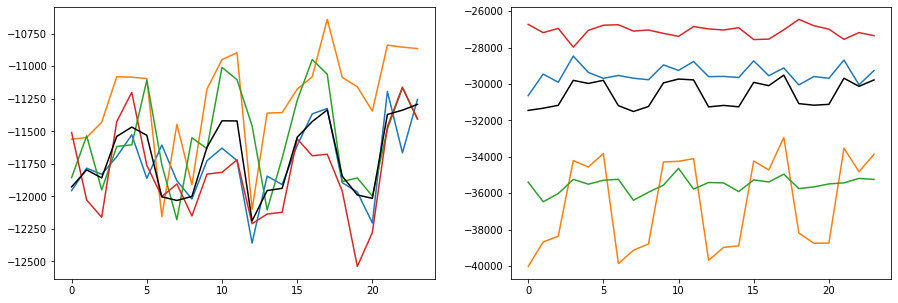

In [21]:
plot_CV_scores(grid_search_rf)

c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


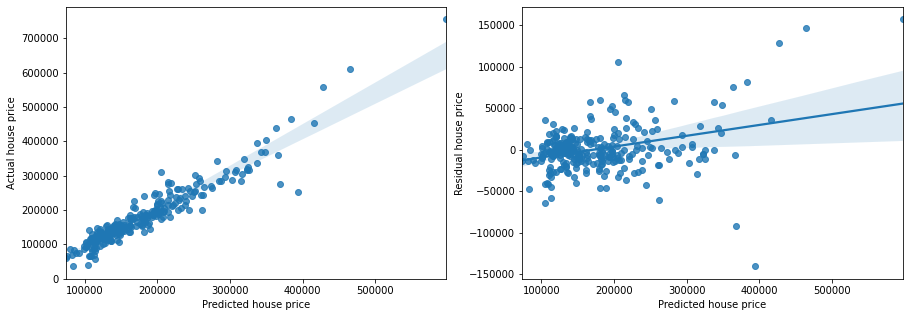

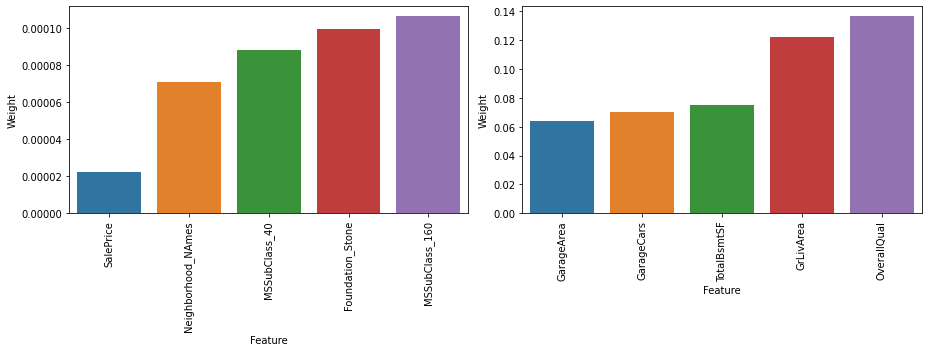

In [22]:
summary_plots(results_rf, y_test.values, feature_labels, rf_final.feature_importances_)

# XGBoost [Return](#ToC) <a id = 'XGB'></a>

In [23]:
train_dmatrix = xgb.DMatrix(data = X_train, label = y_train)
test_dmatrix = xgb.DMatrix(data = X_test, label = y_test)


param_grid = {'learning_rate': [0.01, 0.1, 0.3],
              'max_depth': [5, 10, 50],
              'subsample': [0.3, 0.5, 0.7],
              'colsample_bytree': [0.3, 0.5, 0.7],
              "gamma": [ 0.0, 0.2, 0.4]
              }
xgr = xgb.XGBRegressor(n_estimators = 100)
grid_search_xgb = GridSearchCV(estimator = xgr, param_grid = param_grid, 
                              cv = 5, 
                              return_train_score = True,
                              scoring = 'neg_root_mean_squared_error')
_ = grid_search_xgb.fit(X_train, y_train)
print(grid_search_xgb.best_params_)
print(grid_search_xgb.score(X_train, y_train))
xgb_final = xgb.XGBRegressor(**grid_search_xgb.best_params_)
xgb_final.fit(X_train, y_train)
results_xgb = xgb_final.predict(X_test)
print(f'Pearson co-efficient: {xgb_final.score(X_test, y_test)}')
print(f'RMSE: {np.sqrt(mean_squared_error(results_xgb, y_test.values))}')
print(f'MAD: {stats.median_absolute_deviation(results_xgb - y_test.values)}')

{'colsample_bytree': 0.3, 'gamma': 0.0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 0.7}
-13531.631077215152
Pearson co-efficient: 0.9060273459516686
RMSE: 26847.73567930536
MAD: 18659.511330468747


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\ipykernel_launcher.py:24: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.



c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


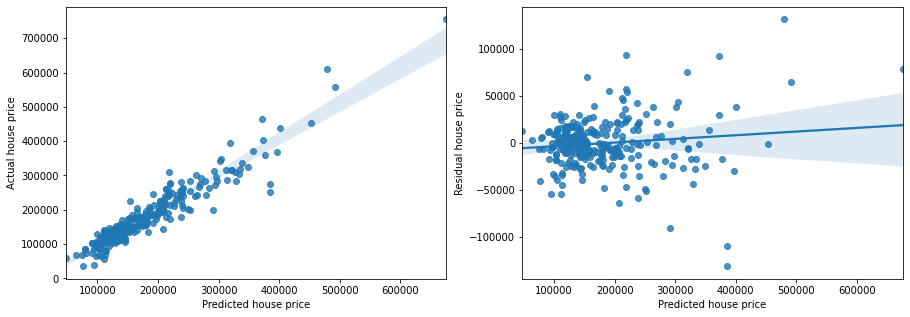

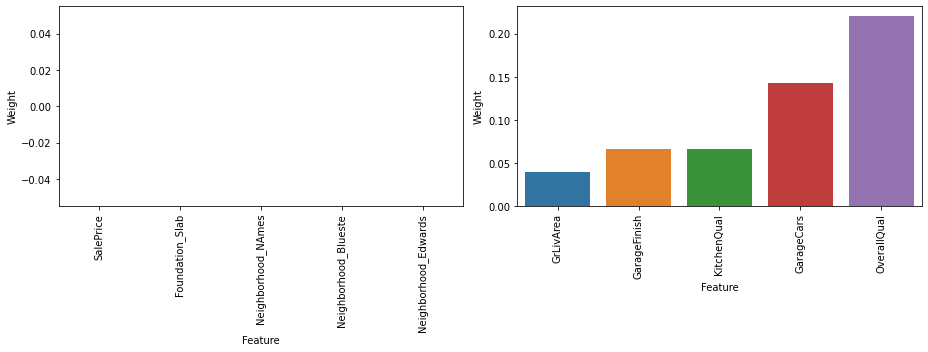

In [24]:
summary_plots(results_xgb, y_test.values, feature_labels, xgb_final.feature_importances_)

# Neural Network [Return](#ToC) <a id = 'NN'></a>

In [25]:
model = Sequential()
model.add(Dense(100, activation = 'relu', input_shape = (X_train.shape[1],)))
model.add(Dense(100, activation = 'relu'))
model.add(Dense(10, activation = 'relu'))
model.add(Dense(1, activation = 'relu'))
print(model.summary())
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs = 1000, verbose = 0)
results_nn = model.predict(X_test)
print(f'RMSE: {np.sqrt(mean_squared_error(results_nn[:, 0], y_test.values))}')
print(f'MAD: {stats.median_absolute_deviation(results_nn[:, 0] - y_test.values)}')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               6600      
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 11        
Total params: 17,721
Trainable params: 17,721
Non-trainable params: 0
_________________________________________________________________
None
RMSE: 31681.166700585203
MAD: 19718.1282703125


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  # This is added back by InteractiveShellApp.init_path()


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\numpy\linalg\linalg.py:1965: RuntimeWarning: invalid value encountered in greater
  large = s > cutoff


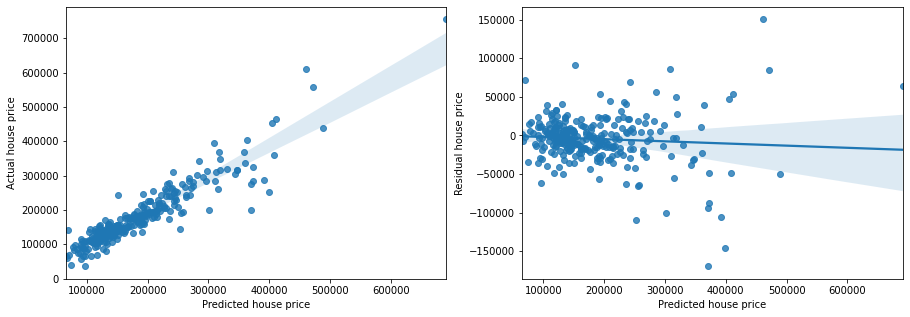

In [26]:
summary_plots(results_nn[:, 0], y_test.values, plot_importance = False)

# Combining Results [Return](#ToC) <a id = "Ensemble"></a>

RMSE: 27622.127437820553
MAD: 17246.87858180356


c:\users\kris mcglinchey\.virtualenvs\ames_dataset_regression-ukumnbpt\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `median_absolute_deviation` is deprecated, use `median_abs_deviation` instead!

To preserve the existing default behavior, use
`scipy.stats.median_abs_deviation(..., scale=1/1.4826)`.
The value 1.4826 is not numerically precise for scaling
with a normal distribution. For a numerically precise value, use
`scipy.stats.median_abs_deviation(..., scale='normal')`.

  This is separate from the ipykernel package so we can avoid doing imports until


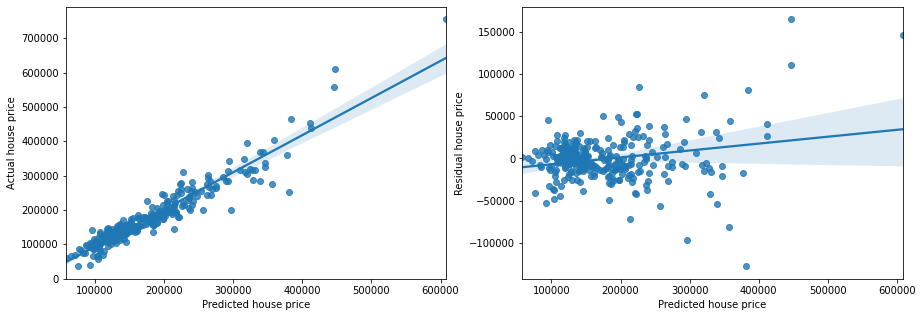

In [27]:
results_ensemble = 0.25 * (results_lasso + results_rf + results_xgb + results_nn[:, 0])
print(f'RMSE: {np.sqrt(mean_squared_error(results_ensemble, y_test.values))}')
print(f'MAD: {stats.median_absolute_deviation(results_ensemble - y_test.values)}')
summary_plots(results_ensemble, y_test.values, plot_importance = False)